# Engineering of Immigration Data in the United States
### Data Engineering Capstone Project

#### Project Summary
In this project, we will conduct a study on Immigration Data in the united states with regards to World Temperature Data, U.S. City Demographic Data, and Airport Code Data. That is to answer questions such as, what is the percentage of people that immigrate to the U.S from countries with cooler weather?, etc..

The goal is to create ETL pipelines that extract each dataset from the source, apply several levels of transformation, then make it ready to be loaded into an analytics database (data warehouse) with a new consolidated data model that serves the analysis and study needs.

The project follows the following steps:
* Step 1: Scope the Project and Gather Data
* Step 2: Explore and Assess the Data
* Step 3: Define the Data Model
* Step 4: Run ETL to Model the Data
* Step 5: Complete Project Write Up

In [1]:
# Do all imports and installs here
import pandas as pd
import matplotlib.pyplot as plt
from pyspark.sql.types import DoubleType, StringType, IntegerType, FloatType, DateType, StructType, StructField

import utils, schema_tables, clean_tables

%matplotlib inline

### Step 1: Scope the Project and Gather Data

#### Scope 
**Explain what you plan to do in the project in more detail. What data do you use? What is your end solution look like? What tools did you use?**

The scope of the project is to create a data warehouse that is suitable for analysis purposes using Apache Spark. It includes extracting data from several sources, transforming each dataset to a specific form, then loading them into a new data model.

This data warehouse will be used to analyze the U.S. immigration data regarding several perspectives, such as world tempreture, demographic data, and others. In the end, every step needed to create the new data model will be pipelined to make it reusable and consistent.

#### Describe and Gather Data 
**Describe the data sets you're using. Where did it come from? What type of information is included?**

Here is an outline about the datasets:
- **I94 Immigration Data:** This data comes from the US National Tourism and Trade Office. [This](https://travel.trade.gov/research/reports/i94/historical/2016.html) is where the data comes from. There's a sample file so you can take a look at the data in csv format before reading it all in. You do not have to use the entire dataset, just use what you need to accomplish the goal you set at the beginning of the project.
- **World Temperature Data:** This dataset came from Kaggle. You can read more about it [here](https://www.kaggle.com/berkeleyearth/climate-change-earth-surface-temperature-data).
- **U.S. City Demographic Data:** This data comes from OpenSoft. You can read more about it [here](https://public.opendatasoft.com/explore/dataset/us-cities-demographics/export/).
- **Airport Code Table:** This is a simple table of airport codes and corresponding cities. It comes from [here](https://datahub.io/core/airport-codes#data).

In [2]:
from pyspark.sql import SparkSession

# create spark session
spark = SparkSession.builder.\
config("spark.jars.repositories", "https://repos.spark-packages.org/").\
config("spark.jars.packages", "saurfang:spark-sas7bdat:2.0.0-s_2.11").\
enableHiveSupport().getOrCreate()

df_spark = spark.read.format('com.github.saurfang.sas.spark').load('../../data/18-83510-I94-Data-2016/i94_apr16_sub.sas7bdat')

In [3]:
# size of the immigration data
df_spark.count()

3096313

In [8]:
# write to parquet
# df_spark.write.parquet("sas_data")
# df_spark = spark.read.parquet("sas_data")

#### Immigration Data

In [3]:
# Read in a sample Immigration data 
immigration_df_sample = pd.read_csv('./data/immigration_data_sample.csv')

In [4]:
pd.set_option('display.max_columns', None)
immigration_df_sample.head()

,Unnamed: 0,cicid,i94yr,i94mon,i94cit,i94res,i94port,arrdate,i94mode,i94addr,depdate,i94bir,i94visa,count,dtadfile,visapost,occup,entdepa,entdepd,entdepu,matflag,biryear,dtaddto,gender,insnum,airline,admnum,fltno,visatype
0,2027561,4084316.0,2016.0,4.0,209.0,209.0,HHW,20566.0,1.0,HI,20573.0,61.0,2.0,1.0,20160422,NaN,NaN,G,O,NaN,M,1955.0,07202016,F,NaN,JL,5.658267e+10,00782,WT
1,2171295,4422636.0,2016.0,4.0,582.0,582.0,MCA,20567.0,1.0,TX,20568.0,26.0,2.0,1.0,20160423,MTR,NaN,G,R,NaN,M,1990.0,10222016,M,NaN,*GA,9.436200e+10,XBLNG,B2
2,589494,1195600.0,2016.0,4.0,148.0,112.0,OGG,20551.0,1.0,FL,20571.0,76.0,2.0,1.0,20160407,NaN,NaN,G,O,NaN,M,1940.0,07052016,M,NaN,LH,5.578047e+10,00464,WT
3,2631158,5291768.0,2016.0,4.0,297.0,297.0,LOS,20572.0,1.0,CA,20581.0,25.0,2.0,1.0,20160428,DOH,NaN,G,O,NaN,M,1991.0,10272016,M,NaN,QR,9.478970e+10,00739,B2
4,3032257,985523.0,2016.0,4.0,111.0,111.0,CHM,20550.0,3.0,NY,20553.0,19.0,2.0,1.0,20160406,NaN,NaN,Z,K,NaN,M,1997.0,07042016,F,NaN,NaN,4.232257e+10,LAND,WT


In [5]:
immigration_df_sample.shape

(1000, 29)

#### Data Dictionary

| Feature  |Description
| --------|-----------
| cicid    |Unique record ID
| i94yr    |year
| i94mon   |month of the arrival
| i94cit   |3 digit code for immigrant country of citizenship
| i94res   |3 digit code for immigrant country of residence
| i94port  |Port of admission
| arrdate  |Arrival Date in the USA
| i94mode  |Mode of transportation (1 = Air; 2 = Sea; 3 = Land; 9 = Not reported)
| i94addr  |USA State of arrival
| depdate  |Departure Date from the USA
| i94bir   |Age of Respondent in Years
| i94visa  |Visa codes collapsed into three categories
| count    |Field used for summary statistics
| dtadfile |Character Date Field - Date added to I-94 Files
| visapost |Department of State where Visa was issued
| occup    |Occupation that will be performed in U.S
| entdepa  |Arrival Flag - admitted or paroled into the U.S.and others
| entdepd  |Departure Flag - Departed, lost I-94 or is deceased and others
| entdepu  |Update Flag - Either apprehended, overstayed, adjusted to perm residence
| matflag  |Match Flag - Match of arrival and departure records
| biryear  |4 digit year of birth
| dtaddto  |Character Date Field - Date to which admitted to U.S. (allowed to stay until)
| gender   |Non-immigrant sex
| insnum   |INS number
| airline  |Airline used to arrive in U.S.
| admnum   |Admission Number
| fltno    |Flight number of Airline used to arrive in U.S.
| visatype |Class of admission legally admitting the non-immigrant to temporarily stay in U.S.

This dataset forms the core of the data warehouse and the provider repository has a year worth of data for the year 2016 and it is divided by month. For this project we have chosen going to work with data for the month of April. However, the ETL pipeline functions have been designed to work with any month's worth of data. 

In [7]:
# read immaigration data labels Descriptions
i94cit_res, i94port, i94mode, i94addr, i94visa = utils.read_immigration_labels('./I94_SAS_Labels_Descriptions.SAS')

The meaning of the flags in the columns *entdepa, entdepd, and entdepu* should be referred like below:
- G -> Admitted into US
- O -> Paroled into US
- R -> Departed
- K -> Lost I 94 or is deceased
- N -> Apprehended
- T -> Overstayed
- Z -> Adjusted to perm residence

#### Temperature data

In [8]:
# read temperature data
fname = '../../data2/GlobalLandTemperaturesByCity.csv'
temperature_df = pd.read_csv(fname)

In [9]:
temperature_df.head()

,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude
0,1743-11-01,6.068,1.737,Århus,Denmark,57.05N,10.33E
1,1743-12-01,NaN,NaN,Århus,Denmark,57.05N,10.33E
2,1744-01-01,NaN,NaN,Århus,Denmark,57.05N,10.33E
3,1744-02-01,NaN,NaN,Århus,Denmark,57.05N,10.33E
4,1744-03-01,NaN,NaN,Århus,Denmark,57.05N,10.33E


In [10]:
temperature_df.shape

(8599212, 7)

#### Data Dictionary

| Feature | Description
| --------|-----------
| dt | Date
| AverageTemperature | Average temperature in celsius
| AverageTemperatureUncertainty | 95% confidence interval around average temperature
| City | Name of city
| Country | Name of country
| Latitude | Latitude of city
| Longitude | Longitude of city


This dataset contains temperature data in various cities from the 1700’s to 2013. Although the data is only recorded until 2013, we can use this as an estimate of future years' temperature.

#### U.S. City Demographic Data

In [11]:
# read demographic data
demographics_df = pd.read_csv('./data/us-cities-demographics.csv', sep=';')

In [12]:
demographics_df.head()

,City,State,Median Age,Male Population,Female Population,Total Population,Number of Veterans,Foreign-born,Average Household Size,State Code,Race,Count
0,Silver Spring,Maryland,33.8,40601.0,41862.0,82463,1562.0,30908.0,2.60,MD,Hispanic or Latino,25924
1,Quincy,Massachusetts,41.0,44129.0,49500.0,93629,4147.0,32935.0,2.39,MA,White,58723
2,Hoover,Alabama,38.5,38040.0,46799.0,84839,4819.0,8229.0,2.58,AL,Asian,4759
3,Rancho Cucamonga,California,34.5,88127.0,87105.0,175232,5821.0,33878.0,3.18,CA,Black or African-American,24437
4,Newark,New Jersey,34.6,138040.0,143873.0,281913,5829.0,86253.0,2.73,NJ,White,76402


In [13]:
demographics_df.shape

(2891, 12)

#### Data Dictionary

| Feature	| Description
| --------|-----------
| City	| City Name
| State	| US State of the City
| Median Age	| The median population age
| Male Population	| Male population total
| Female Population	| Female population total
| Total Population	| Total population
| Number of Veterans	| Number of veterans living in the city
| Foreign-born	| Number of residents who were not born in the city
| Average Household Size	| Average size of houses in the city
| State Code	| Code of the state
| Race	| Race class
| Count	| Number of individuals in each race

#### Airport Codes Data

In [14]:
# read airport codes data
airport_df = pd.read_csv('./data/airport-codes_csv.csv')

In [15]:
airport_df.head()

,ident,type,name,elevation_ft,continent,iso_country,iso_region,municipality,gps_code,iata_code,local_code,coordinates
0,00A,heliport,Total Rf Heliport,11.0,NaN,US,US-PA,Bensalem,00A,NaN,00A,"-74.93360137939453, 40.07080078125"
1,00AA,small_airport,Aero B Ranch Airport,3435.0,NaN,US,US-KS,Leoti,00AA,NaN,00AA,"-101.473911, 38.704022"
2,00AK,small_airport,Lowell Field,450.0,NaN,US,US-AK,Anchor Point,00AK,NaN,00AK,"-151.695999146, 59.94919968"
3,00AL,small_airport,Epps Airpark,820.0,NaN,US,US-AL,Harvest,00AL,NaN,00AL,"-86.77030181884766, 34.86479949951172"
4,00AR,closed,Newport Hospital & Clinic Heliport,237.0,NaN,US,US-AR,Newport,NaN,NaN,NaN,"-91.254898, 35.6087"


In [16]:
airport_df.shape

(55075, 12)

#### Data Dictionary

| Feature	| Description
| --------|-----------
| ident	| Unique ID
| type	| Airport type
| name	| Airport name
| elevation_ft	| Airport altitude
| continent	| Continent
| iso_country	| ISO Code of the airport's country
| iso_region	| ISO Code for the airport's region
| municipality	| City/Municipality where the airport is located
| gps_code	| Airport GPS Code
| iata_code	| Airport IATA Code
| local_code	| Airport local code
| coordinates	| Airport coordinates

### Step 2: Explore and Assess the Data
#### Exploring & Cleaning the Data 
Identify data quality issues, like missing values, duplicate data, etc.

Document steps necessary to clean the data

#### Immigration Data

In [36]:
df_spark.limit(4).toPandas()

,cicid,i94yr,i94mon,i94cit,i94res,i94port,arrdate,i94mode,i94addr,depdate,i94bir,i94visa,count,dtadfile,visapost,occup,entdepa,entdepd,entdepu,matflag,biryear,dtaddto,gender,insnum,airline,admnum,fltno,visatype
0,6.0,2016.0,4.0,692.0,692.0,XXX,20573.0,NaN,None,NaN,37.0,2.0,1.0,None,None,None,T,None,U,None,1979.0,10282016,None,None,None,1.897628e+09,None,B2
1,7.0,2016.0,4.0,254.0,276.0,ATL,20551.0,1.0,AL,NaN,25.0,3.0,1.0,20130811,SEO,None,G,None,Y,None,1991.0,D/S,M,None,None,3.736796e+09,00296,F1
2,15.0,2016.0,4.0,101.0,101.0,WAS,20545.0,1.0,MI,20691.0,55.0,2.0,1.0,20160401,None,None,T,O,None,M,1961.0,09302016,M,None,OS,6.666432e+08,93,B2
3,16.0,2016.0,4.0,101.0,101.0,NYC,20545.0,1.0,MA,20567.0,28.0,2.0,1.0,20160401,None,None,O,O,None,M,1988.0,09302016,None,None,AA,9.246846e+10,00199,B2


In [19]:
# show the immigration data schema
df_spark.printSchema()

root
 |-- cicid: double (nullable = true)
 |-- i94yr: double (nullable = true)
 |-- i94mon: double (nullable = true)
 |-- i94cit: double (nullable = true)
 |-- i94res: double (nullable = true)
 |-- i94port: string (nullable = true)
 |-- arrdate: double (nullable = true)
 |-- i94mode: double (nullable = true)
 |-- i94addr: string (nullable = true)
 |-- depdate: double (nullable = true)
 |-- i94bir: double (nullable = true)
 |-- i94visa: double (nullable = true)
 |-- count: double (nullable = true)
 |-- dtadfile: string (nullable = true)
 |-- visapost: string (nullable = true)
 |-- occup: string (nullable = true)
 |-- entdepa: string (nullable = true)
 |-- entdepd: string (nullable = true)
 |-- entdepu: string (nullable = true)
 |-- matflag: string (nullable = true)
 |-- biryear: double (nullable = true)
 |-- dtaddto: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- insnum: string (nullable = true)
 |-- airline: string (nullable = true)
 |-- admnum: double (nullable = 

In [27]:
# percentage of null values (drop columns with more than 90% null values)
(df_spark.select([count(when(col(c).contains('None') | \
                            col(c).contains('NULL') | \
                            (col(c) == '' ) | \
                            col(c).isNull() | \
                            isnan(c), c 
                           )).alias(c)
                    for c in df_spark.columns]).toPandas() / df_spark.count()) * 100

,cicid,i94yr,i94mon,i94cit,i94res,i94port,arrdate,i94mode,i94addr,depdate,i94bir,i94visa,count,dtadfile,visapost,occup,entdepa,entdepd,entdepu,matflag,biryear,dtaddto,gender,insnum,airline,admnum,fltno,visatype
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.007719,4.928184,4.600859,0.025902,0.0,0.0,0.000032,60.757746,99.737559,0.007687,4.470769,99.98734,4.470769,0.025902,0.015405,13.379429,96.327632,2.700857,0.0,0.631364,0.0


In [26]:
# number of duplicates rows (drop duplictaed rows)
df_spark.distinct().count() == df_spark.count()

True

In [17]:
immigration_df_sample.head()

,Unnamed: 0,cicid,i94yr,i94mon,i94cit,i94res,i94port,arrdate,i94mode,i94addr,depdate,i94bir,i94visa,count,dtadfile,visapost,occup,entdepa,entdepd,entdepu,matflag,biryear,dtaddto,gender,insnum,airline,admnum,fltno,visatype
0,2027561,4084316.0,2016.0,4.0,209.0,209.0,HHW,20566.0,1.0,HI,20573.0,61.0,2.0,1.0,20160422,NaN,NaN,G,O,NaN,M,1955.0,07202016,F,NaN,JL,5.658267e+10,00782,WT
1,2171295,4422636.0,2016.0,4.0,582.0,582.0,MCA,20567.0,1.0,TX,20568.0,26.0,2.0,1.0,20160423,MTR,NaN,G,R,NaN,M,1990.0,10222016,M,NaN,*GA,9.436200e+10,XBLNG,B2
2,589494,1195600.0,2016.0,4.0,148.0,112.0,OGG,20551.0,1.0,FL,20571.0,76.0,2.0,1.0,20160407,NaN,NaN,G,O,NaN,M,1940.0,07052016,M,NaN,LH,5.578047e+10,00464,WT
3,2631158,5291768.0,2016.0,4.0,297.0,297.0,LOS,20572.0,1.0,CA,20581.0,25.0,2.0,1.0,20160428,DOH,NaN,G,O,NaN,M,1991.0,10272016,M,NaN,QR,9.478970e+10,00739,B2
4,3032257,985523.0,2016.0,4.0,111.0,111.0,CHM,20550.0,3.0,NY,20553.0,19.0,2.0,1.0,20160406,NaN,NaN,Z,K,NaN,M,1997.0,07042016,F,NaN,NaN,4.232257e+10,LAND,WT


In [18]:
# quick view of the data info.
immigration_df_sample.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 29 columns):
Unnamed: 0    1000 non-null int64
cicid         1000 non-null float64
i94yr         1000 non-null float64
i94mon        1000 non-null float64
i94cit        1000 non-null float64
i94res        1000 non-null float64
i94port       1000 non-null object
arrdate       1000 non-null float64
i94mode       1000 non-null float64
i94addr       941 non-null object
depdate       951 non-null float64
i94bir        1000 non-null float64
i94visa       1000 non-null float64
count         1000 non-null float64
dtadfile      1000 non-null int64
visapost      382 non-null object
occup         4 non-null object
entdepa       1000 non-null object
entdepd       954 non-null object
entdepu       0 non-null float64
matflag       954 non-null object
biryear       1000 non-null float64
dtaddto       1000 non-null object
gender        859 non-null object
insnum        35 non-null float64
airline       967 non

In [19]:
# clean Immigration_df_sample table
clean_immigration_df_sample = clean_tables.clean_immigration_table(immigration_df_sample, process_spark=False)

Percentage of null values:
Unnamed: 0      0.0
cicid           0.0
i94yr           0.0
i94mon          0.0
i94cit          0.0
i94res          0.0
i94port         0.0
arrdate         0.0
i94mode         0.0
i94addr         5.9
depdate         4.9
i94bir          0.0
i94visa         0.0
count           0.0
dtadfile        0.0
visapost       61.8
occup          99.6
entdepa         0.0
entdepd         4.6
entdepu       100.0
matflag         4.6
biryear         0.0
dtaddto         0.0
gender         14.1
insnum         96.5
airline         3.3
admnum          0.0
fltno           0.8
visatype        0.0

Columns to be dropped: ['occup', 'entdepu', 'insnum']

Number of duplicate rows: 0

Number of rows where all values are missing: 0

Drop miss index columns if exist (Unnamed): ['Unnamed: 0']


#### Temperature data

In [20]:
temperature_df.head()

,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude
0,1743-11-01,6.068,1.737,Århus,Denmark,57.05N,10.33E
1,1743-12-01,NaN,NaN,Århus,Denmark,57.05N,10.33E
2,1744-01-01,NaN,NaN,Århus,Denmark,57.05N,10.33E
3,1744-02-01,NaN,NaN,Århus,Denmark,57.05N,10.33E
4,1744-03-01,NaN,NaN,Århus,Denmark,57.05N,10.33E


In [21]:
# min and max date
temperature_df['dt'].min(), temperature_df['dt'].max()

('1743-11-01', '2013-09-01')

In [22]:
# quick view of the data info.
temperature_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8599212 entries, 0 to 8599211
Data columns (total 7 columns):
dt                               object
AverageTemperature               float64
AverageTemperatureUncertainty    float64
City                             object
Country                          object
Latitude                         object
Longitude                        object
dtypes: float64(2), object(5)
memory usage: 459.2+ MB


In [23]:
# clean temperature table
clean_temperature_df = clean_tables.clean_temperature_table(temperature_df)

Percentage of null values:
dt                               0.0
AverageTemperature               0.0
AverageTemperatureUncertainty    0.0
City                             0.0
Country                          0.0
Latitude                         0.0
Longitude                        0.0

No columns to be dropped

Number of duplicate rows: 0

Number of rows where all values are missing: 0

Drop miss index columns if exist (Unnamed): []


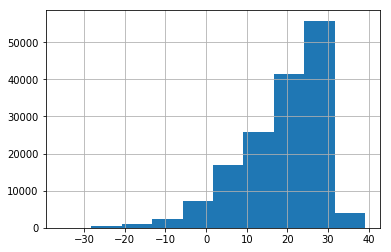

In [24]:
# Histogram of Average Temperature values
clean_temperature_df['AverageTemperature'].hist();

#### U.S. City Demographic data

In [25]:
demographics_df.head()

,City,State,Median Age,Male Population,Female Population,Total Population,Number of Veterans,Foreign-born,Average Household Size,State Code,Race,Count
0,Silver Spring,Maryland,33.8,40601.0,41862.0,82463,1562.0,30908.0,2.60,MD,Hispanic or Latino,25924
1,Quincy,Massachusetts,41.0,44129.0,49500.0,93629,4147.0,32935.0,2.39,MA,White,58723
2,Hoover,Alabama,38.5,38040.0,46799.0,84839,4819.0,8229.0,2.58,AL,Asian,4759
3,Rancho Cucamonga,California,34.5,88127.0,87105.0,175232,5821.0,33878.0,3.18,CA,Black or African-American,24437
4,Newark,New Jersey,34.6,138040.0,143873.0,281913,5829.0,86253.0,2.73,NJ,White,76402


In [26]:
# quick view of the data info.
demographics_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2891 entries, 0 to 2890
Data columns (total 12 columns):
City                      2891 non-null object
State                     2891 non-null object
Median Age                2891 non-null float64
Male Population           2888 non-null float64
Female Population         2888 non-null float64
Total Population          2891 non-null int64
Number of Veterans        2878 non-null float64
Foreign-born              2878 non-null float64
Average Household Size    2875 non-null float64
State Code                2891 non-null object
Race                      2891 non-null object
Count                     2891 non-null int64
dtypes: float64(6), int64(2), object(4)
memory usage: 271.1+ KB


In [27]:
# clean demographics table
clean_demographics_df = clean_tables.clean_demographics_table(demographics_df)

Percentage of null values:
City                      0.00
State                     0.00
Median Age                0.00
Male Population           0.10
Female Population         0.10
Total Population          0.00
Number of Veterans        0.45
Foreign-born              0.45
Average Household Size    0.55
State Code                0.00
Race                      0.00
Count                     0.00

No columns to be dropped

Number of duplicate rows: 0

Number of rows where all values are missing: 0

Drop miss index columns if exist (Unnamed): []


#### Airport Codes data

In [28]:
airport_df.head()

,ident,type,name,elevation_ft,continent,iso_country,iso_region,municipality,gps_code,iata_code,local_code,coordinates
0,00A,heliport,Total Rf Heliport,11.0,NaN,US,US-PA,Bensalem,00A,NaN,00A,"-74.93360137939453, 40.07080078125"
1,00AA,small_airport,Aero B Ranch Airport,3435.0,NaN,US,US-KS,Leoti,00AA,NaN,00AA,"-101.473911, 38.704022"
2,00AK,small_airport,Lowell Field,450.0,NaN,US,US-AK,Anchor Point,00AK,NaN,00AK,"-151.695999146, 59.94919968"
3,00AL,small_airport,Epps Airpark,820.0,NaN,US,US-AL,Harvest,00AL,NaN,00AL,"-86.77030181884766, 34.86479949951172"
4,00AR,closed,Newport Hospital & Clinic Heliport,237.0,NaN,US,US-AR,Newport,NaN,NaN,NaN,"-91.254898, 35.6087"


In [29]:
# quick view of the data info.
airport_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55075 entries, 0 to 55074
Data columns (total 12 columns):
ident           55075 non-null object
type            55075 non-null object
name            55075 non-null object
elevation_ft    48069 non-null float64
continent       27356 non-null object
iso_country     54828 non-null object
iso_region      55075 non-null object
municipality    49399 non-null object
gps_code        41030 non-null object
iata_code       9189 non-null object
local_code      28686 non-null object
coordinates     55075 non-null object
dtypes: float64(1), object(11)
memory usage: 5.0+ MB


In [30]:
# clean airport table
clean_airport_df = clean_tables.clean_airport_table(airport_df)

Percentage of null values:
ident            0.00
type             0.00
name             0.00
elevation_ft    12.72
continent       50.33
iso_country      0.45
iso_region       0.00
municipality    10.31
gps_code        25.50
iata_code       83.46
local_code      47.91
coordinates      0.10

No columns to be dropped

Number of duplicate rows: 0

Number of rows where all values are missing: 0

Drop miss index columns if exist (Unnamed): []


### Step 3: Define the Data Model

#### 3.1 Conceptual Data Model
**Map out the conceptual data model and explain why you chose that model**

![conceptual data model](conceptual_data_model.png "Conceptual Data Model")

The data model here represents immigration instances with regard to airport data, demographic data, temperature data, and others. The model is designed as a **Star schema** in the data warehouse, where the desired immigration facts and info are in the fact table, and other perspective information and features that include an object in the fact table are dimension tables. The star schema is suitable for the analytics purposes of immigration study, since it connects relevant information within a proper number of aggregations and links (fewer joins), and decreases the records duplication at an adequate level with respect to schema complexity.

Some dimensions are a set of related information extracted from the original immigration dataset to construct a more-structured and less-duplicated schema. Other dimensions are datasets transformed to accommodate with immigration analysis level and reference with the fact table. The first case includes *data, visa, migrant, and status dimensions*. The second case includes:
- *country temperature dimension*, which is formed by grouping the temperature dataset records by country and joining it with country code mapping information.
- *Airport dimension*, which is formed by taking the records of unique IATA code values, since it has the highest intersection with i94port values in the fact table, which therefore provide more beneficial information for the analysis and make the best use of the airport dataset.
- *demographics dimension*, which is formed by grouping the demographics dataset records by state, since we are interested in state analysis level with i94addr values in the fact table, and to gain more information out of the demographics dataset.

**Fact table:**
- Immigration table

**Dimension tables:**
1. Migrant
1. Status
1. Visa
1. Demographics
1. Airport
1. Country Temperature
1. Date

#### 3.2 Mapping Out Data Pipelines
**List the steps necessary to pipeline the data into the chosen data model:**
1. Clean the data (Applied in Step 2).
1. Create Dimension tables.
1. Create Fact table.
1. Write data into parquet files.
1. Perform data quality checks.

### Step 4: Run Pipelines to Model the Data 
#### 4.1 Create the data model
Build the data pipelines to create the data model.

In [31]:
# specify the schema of each dataset to read them correctly
# 1) immigration dataset
immigration_schema = StructType([StructField("cicid", FloatType(), True),
                                 StructField("i94yr", FloatType(), True),
                                 StructField("i94mon", FloatType(), True),
                                 StructField("i94cit", FloatType(), True),
                                 StructField("i94res", FloatType(), True),
                                 StructField("i94port", StringType(), True),
                                 StructField("arrdate", FloatType(), True),
                                 StructField("i94mode", FloatType(), True),
                                 StructField("i94addr", StringType(), True),
                                 StructField("depdate", FloatType(), True),
                                 StructField("i94bir", FloatType(), True),
                                 StructField("i94visa", FloatType(), True),
                                 StructField("count", FloatType(), True),
                                 StructField("dtadfile", StringType(), True),
                                 StructField("visapost", StringType(), True),
                                 StructField("entdepa", StringType(), True),
                                 StructField("entdepd", StringType(), True),
                                 StructField("matflag", StringType(), True),
                                 StructField("biryear", FloatType(), True),
                                 StructField("dtaddto", StringType(), True),
                                 StructField("gender", StringType(), True),
                                 StructField("airline", StringType(), True),
                                 StructField("admnum", FloatType(), True),
                                 StructField("fltno", StringType(), True),
                                 StructField("visatype", StringType(), True)])

immigration_df_spark = spark.createDataFrame(clean_immigration_df_sample, schema=immigration_schema)

# 2) temperature dataset
temperature_schema = StructType([StructField("dt", DateType(), True),
                                 StructField("AverageTemperature", FloatType(), True),
                                 StructField("AverageTemperatureUncertainty", FloatType(), True),
                                 StructField("City", StringType(), True),
                                 StructField("Country", StringType(), True),
                                 StructField("Latitude", FloatType(), True), 
                                 StructField("Longitude", FloatType(), True)])

temperature_df_spark = spark.createDataFrame(clean_temperature_df, schema=temperature_schema)

# 3) demographics dataset
demographics_schema = StructType([StructField("City", StringType(), True), 
                                  StructField("State", StringType(), True), 
                                  StructField("Median Age", FloatType(), True), 
                                  StructField("Male Population", FloatType(), True), 
                                  StructField("Female Population", FloatType(), True), 
                                  StructField("Total Population", IntegerType(), True), 
                                  StructField("Number of Veterans", FloatType(), True), 
                                  StructField("Foreign-born", FloatType(), True), 
                                  StructField("Average Household Size", FloatType(), True), 
                                  StructField("State Code", StringType(), True), 
                                  StructField("Race", StringType(), True),
                                  StructField("Count", IntegerType(), True)])

demographics_df_spark = spark.createDataFrame(clean_demographics_df, schema=demographics_schema)


# 4) airport codes dataset
airport_schema = StructType([StructField("ident", StringType(), True), 
                             StructField("type", StringType(), True), 
                             StructField("name", StringType(), True), 
                             StructField("elevation_ft", FloatType(), True), 
                             StructField("continent", StringType(), True), 
                             StructField("iso_country", StringType(), True), 
                             StructField("iso_region", StringType(), True), 
                             StructField("municipality", StringType(), True), 
                             StructField("gps_code", StringType(), True), 
                             StructField("iata_code", StringType(), True), 
                             StructField("local_code", StringType(), True),
                             StructField("longitude", FloatType(), True),
                             StructField("latitude", FloatType(), True)])

airport_df_spark = spark.createDataFrame(clean_airport_df, schema=airport_schema)

In [6]:
# path where to store fact and dimension tables
output_path = "./data-model-tables/"

#### Dimension tables

#### 1. Migrant dimension table

In [32]:
# create migrant dimension table (dim_migrant)
dim_migrant = schema_tables.create_migrant_dimension(immigration_df_spark, output_path, "migrant")

Writing table migrant to ./data-model-tables/migrant
Write completed with 13.79 sec !


In [31]:
migrant_table = spark.read.parquet("./data-model-tables/migrant")
migrant_table.limit(5).toPandas()

,migrant_id,birth_year,gender
0,16,1995.0,F
1,32,1982.0,M
2,246,1959.0,M
3,573,1972.0,NaN
4,21,1976.0,NaN


#### 2. Status dimension table

In [34]:
# create status dimension table (dim_status)
dim_status = schema_tables.create_status_dimension(immigration_df_spark, output_path, "status")

Writing table status to ./data-model-tables/status
Write completed with 4.83 sec !


In [32]:
status_table = spark.read.parquet("./data-model-tables/status")
status_table.limit(5).toPandas()

,status_flag_id,arrival_flag,departure_flag,match_flag
0,8,O,O,M
1,35,A,D,M
2,105,Z,O,M
3,36,G,NaN,NaN
4,106,O,NaN,NaN


#### 3. Visa dimension table

In [36]:
# create visa dimension table (dim_visa)
dim_visa = schema_tables.create_visa_dimension(immigration_df_spark, output_path, "visa")

Writing table visa to ./data-model-tables/visa
Write completed with 4.95 sec !


In [33]:
visa_table = spark.read.parquet("./data-model-tables/visa")
visa_table.limit(5).toPandas()

,visa_id,i94visa,visatype,visapost
0,13,2.0,B2,MNL
1,139,2.0,B2,GTM
2,706,2.0,B2,CDJ
3,937,2.0,B2,NRB
4,32,2.0,B2,CPT


#### 4. Demographics dimension table

In [38]:
# create demographics dimension table (dim_demographics)
dim_demographics = schema_tables.create_demographics_dimension(demographics_df_spark, output_path, "demographics")

Writing table demographics to ./data-model-tables/demographics
Write completed with 4.51 sec !


In [34]:
demographics_table = spark.read.parquet("./data-model-tables/demographics")
demographics_table.limit(5).toPandas()

,state_code,state,median_age,total_population,male_population,female_population,foreign_born,average_household_size
0,DC,District of Columbia,33.80,3361140,1598525.0,1762615.0,475585.0,2.24
1,AR,Arkansas,32.74,2882889,1400724.0,1482165.0,307753.0,2.53
2,TN,Tennessee,34.31,10690165,5124189.0,5565976.0,900149.0,2.46
3,LA,Louisiana,34.63,6502975,3134990.0,3367985.0,417095.0,2.47
4,AZ,Arizona,35.04,22497710,11137275.0,11360435.0,3411565.0,2.77


#### 5. Airport dimension table

In [40]:
# create airport dimension table (dim_airport)
dim_airport = schema_tables.create_airport_dimension(airport_df_spark, output_path, "airport")

Writing table airport to ./data-model-tables/airport
Write completed with 11.3 sec !


In [35]:
airport_table = spark.read.parquet("./data-model-tables/airport")
airport_table.limit(5).toPandas()

,iata_code,ident,type,name,elevation_ft,continent,iso_country,iso_region,municipality,gps_code,local_code
0,AMW,KAMW,small_airport,Ames Municipal Airport,956.0,NaN,US,US-IA,Ames,KAMW,AMW
1,ATC,MYCA,medium_airport,Arthur's Town Airport,18.0,NaN,BS,BS-CI,Arthur's Town,MYCA,NaN
2,BIS,KBIS,medium_airport,Bismarck Municipal Airport,1661.0,NaN,US,US-ND,Bismarck,KBIS,BIS
3,BPA,US-BPA,closed,Grumman Bethpage Airport,115.0,NaN,US,US-NY,Bethpage,NaN,NaN
4,BPY,FMNQ,medium_airport,Besalampy Airport,125.0,AF,MG,MG-M,NaN,FMNQ,NaN


#### 6. Country Temperature dimension table

In [33]:
# create country_temperature dimension table (dim_country_temperature)
dim_country_temperature = schema_tables.create_country_temperature_dimension(i94cit_res, temperature_df_spark, output_path, "country_temperature")

Writing table country_temperature to ./data-model-tables/country_temperature
Write completed with 19.8 sec !


In [36]:
country_temperature_table = spark.read.parquet("./data-model-tables/country_temperature")
country_temperature_table.limit(5).toPandas()

,country_code,country_name,average_temperature,average_temperature_uncertainty
0,386.0,Benin,27.85,0.49
1,271.0,Cocos Islands,NaN,NaN
2,403.0,Invalid: American Samoa,NaN,NaN
3,0.0,Invalid: Stateless,NaN,NaN
4,705.0,Invalid: Stateless,NaN,NaN


#### 7. Date dimension table

In [33]:
# create date dimension table (dim_date)
dim_date = schema_tables.create_date_dimension(immigration_df_spark, output_path, "date")

Writing table date to ./data-model-tables/date
Write completed with 21.95 sec !


In [37]:
date_table = spark.read.parquet("./data-model-tables/date")
date_table.limit(5).toPandas()

,date_id,date,year,month,day,weekday
0,20627.0,2016-06-22,2016,6,22,4
1,20592.0,2016-05-18,2016,5,18,4
2,20674.0,2016-08-08,2016,8,8,2
3,20663.0,2016-07-28,2016,7,28,5
4,20585.0,2016-05-11,2016,5,11,4


#### Fact tables

#### Immigration fact table

In [36]:
# create immigration fact table (fact_immigration)
fact_immigration = schema_tables.create_immigration_fact(immigration_df_spark, output_path, "fact_immigration")

Writing table fact_immigration to ./data-model-tables/fact_immigration
Write completed with 3.09 sec !


In [38]:
immigration_table = spark.read.parquet("./data-model-tables/fact_immigration")
immigration_table.limit(5).toPandas()

,cicid,date_id_arrdate,date_id_depdate,country_code_i94cit,country_code_i94res,iata_code_i94port,i94mode,state_code_i94addr,visa_id,status_flag_id,migrant_id,airline,admnum,fltno
0,4084316.0,20566.0,20573.0,209.0,209.0,HHW,1.0,HI,0,0,0,JL,5.658268e+10,00782
1,4422636.0,20567.0,20568.0,582.0,582.0,MCA,1.0,TX,1,1,1,*GA,9.436199e+10,XBLNG
2,1195600.0,20551.0,20571.0,148.0,112.0,OGG,1.0,FL,0,0,2,LH,5.578047e+10,00464
3,5291768.0,20572.0,20581.0,297.0,297.0,LOS,1.0,CA,3,0,3,QR,9.478970e+10,00739
4,985523.0,20550.0,20553.0,111.0,111.0,CHM,3.0,NY,0,4,4,NaN,4.232257e+10,LAND


#### 4.2 Data Quality Checks
Explain the data quality checks you'll perform to ensure the pipeline ran as expected. These could include:
 * Integrity constraints on the relational database (e.g., unique key, data type, etc.)
 * Unit tests for the scripts to ensure they are doing the right thing
 * Source/Count checks to ensure completeness
 
Run Quality Checks

In [39]:
tables = {
    "immigration": immigration_table,
    "airport": airport_table,
    "country temperature": country_temperature_table,
    "migrant": migrant_table,
    "status": status_table,
    "demographics": demographics_table,
    "date": date_table,
    "visa": visa_table
}

for table_name, table in tables.items():
    utils.quality_check_count(table, table_name)

Data quality check (record counting) passed for immigration table with 1,000 records
Data quality check (record counting) passed for airport table with 9,042 records
Data quality check (record counting) passed for country temperature table with 289 records
Data quality check (record counting) passed for migrant table with 215 records
Data quality check (record counting) passed for status table with 34 records
Data quality check (record counting) passed for demographics table with 49 records
Data quality check (record counting) passed for date table with 111 records
Data quality check (record counting) passed for visa table with 149 records


#### 4.3 Data dictionary 
Create a data dictionary for your data model. For each field, provide a brief description of what the data is and where it came from. You can include the data dictionary in the notebook or in a separate file.

- Refer to **data_dictionary.md** file.

#### Step 5: Complete Project Write Up

- Rationale for the choice of tools and technologies for the project:
    - This project uses a variety of big data processing technologies and others, such as: 
        - Apache Spark, for its capacity to process enormous amounts of data, as well as the use of its unified analytics engine and easy-to-use APIs.
        - Pandas, for its practical dataframe manipulation features.
        - Matplotlib, for plotting data and gaining additional insights.

- Propose how often the data should be updated and why:
    - The current I94 immigration data is updated monthly, and therefore the data should be updated accordingly.

- Write a description of how you would approach the problem differently under the following scenarios:
    - The data was increased by 100x.
        - Even though Spark can handle the job but we would use more processing power and increase the number of nodes in the cluster. Also, we would implement the pipeline and engineering work with more sophisticated processing and storage functions such as Amazon Redshift and Amazon EMR.
     
    - The data populates a dashboard that must be updated on a daily basis by 7am every day.
        - In this case, Apache Airflow will be used to schedule and run data pipelines, that is to ensure timeliness, consistency, and stability.
    - The database needed to be accessed by 100+ people.
        - In this scenario, we would move our analytics database into Amazon Redshift which can handle massive request volumes and is easily scalable.